In [1]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
    LSTM,
    GRU,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for RAVDESS dataset
base_path_RAVDESS = "../data/raw/audio_speech_actors_01-24"
# Base path for TESS dataset
base_path_TESS = "../data/raw/TESS_Toronto_emotional_speech_set_data"

# Get all audio files from RAVDESS and TESS datasets
audio_files_ravdess = get_audio_files(base_path_RAVDESS)
audio_files_tess = get_audio_files(base_path_TESS)
audio_files = audio_files_ravdess + audio_files_tess
# Save audio files paths
if not os.path.exists("../data/processed/audio_files.txt"):
    with open("../data/processed/audio_files.txt", "w") as f:
        for item in audio_files:
            f.write("%s\n" % item)
    print("../data/processed/audio_files.txt already exists is created")
else:
    print("../data/processed/audio_files.txt already exists")

../data/processed/audio_files.txt already exists


In [3]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack(
            (
                np.mean(mfccs, axis=1),
                np.mean(chroma, axis=1),
                np.mean(mel, axis=1),
                np.mean(contrast, axis=1),
            )
        )
        return features
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files = []
with open("../data/processed/audio_files.txt", "r") as file:
    audio_files = [line.strip() for line in file.readlines()]

# Extract features from all audio files
features = []
labels = []
label_map_tess = {
    "OAF_angry": 4,
    "OAF_disgust": 6,
    "OAF_Fear": 5,
    "OAF_happy": 2,
    "OAF_Pleasant_surprise": 7,
    "OAF_Sad": 3,
    "OAF_neutral": 0,
    "YAF_angry": 4,
    "YAF_disgust": 6,
    "YAF_fear": 5,
    "YAF_happy": 2,
    "YAF_pleasant_surprised": 7,
    "YAF_sad": 3,
    "YAF_neutral": 0,
}
label_map_ravdess = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7,
}
if not os.path.exists("../data/processed/features.npy"):
    for idx, file in enumerate(audio_files, start=1):
        feature = extract_features(file)
        if feature is not None:
            features.append(feature)
            if "audio_speech_actors_01-24" in file:
                # Extract label from RAVDESS file name
                label = file.split(os.sep)[-1].split("-")[2]
                labels.append(label_map_ravdess[label])
            else:
                # Extract label from TESS file path
                emotion = file.split(os.sep)[-2]
                if emotion in label_map_tess:
                    labels.append(label_map_tess[emotion])
                else:
                    print(f"Skipping {file} with unrecognized emotion: {emotion}")
                    features.pop()  # Remove the feature if label is not recognized
            print(f"Processing file {idx} of {len(audio_files)}")

    print("Feature extraction complete.")
    features = np.array(features)
    np.save("../data/processed/features.npy", features)
    labels = np.array(labels)
    np.save("../data/processed/labels.npy", labels)
else:
    # Load features and labels
    features = np.load("../data/processed/features.npy")
    labels = np.load("../data/processed/labels.npy")

In [4]:
# Convert the features and labels into numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape data to fit the model: (num_samples, timesteps, num_features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [5]:
# Initialize a sequential model
model = Sequential()

# First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
# Input shape is (num_features, 1)
model.add(
    Conv1D(64, 5, padding="same", input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(128, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(256, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Flatten the output for the dense layer
model.add(Flatten())

# Dense layer with 8 units and softmax activation for multi-class classification
model.add(Dense(8))
model.add(Activation("softmax"))

# Define the RMSprop optimizer with a lower learning rate
opt = RMSprop(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

# Print a summary of the model architecture
model.summary()

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,104 (891.03 KB)

 Trainable params: 228,104 (891.03 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model with sparse categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [7]:
# Ensure X_train and X_test are reshaped correctly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3782 - loss: 4.9419 - val_accuracy: 0.5920 - val_loss: 1.0478
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6697 - loss: 0.9243 - val_accuracy: 0.6981 - val_loss: 0.8468
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7328 - loss: 0.7407 - val_accuracy: 0.7441 - val_loss: 0.7310
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7634 - loss: 0.6472 - val_accuracy: 0.7748 - val_loss: 0.6185
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7744 - loss: 0.6251 - val_accuracy: 0.7830 - val_loss: 0.6220
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8014 - loss: 0.5632 - val_accuracy: 0.7866 - val_loss: 0.6129
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8020 - loss: 0.5322 - val_accuracy: 0.7748 - val_loss: 0.5903
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8038 - loss: 0.5312 - val_accurac

Test accuracy: 0.8431603908538818
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.97      0.85      0.90        99
           1       0.58      0.68      0.63        38
           2       0.77      0.83      0.80       118
           3       0.83      0.86      0.84       118
           4       0.93      0.89      0.91       119
           5       0.83      0.84      0.83       119
           6       0.83      0.87      0.85       119
           7       0.91      0.81      0.86       118

    accuracy                           0.84       848
   macro avg       0.83      0.83      0.83       848
weighted avg       0.85      0.84      0.84       848



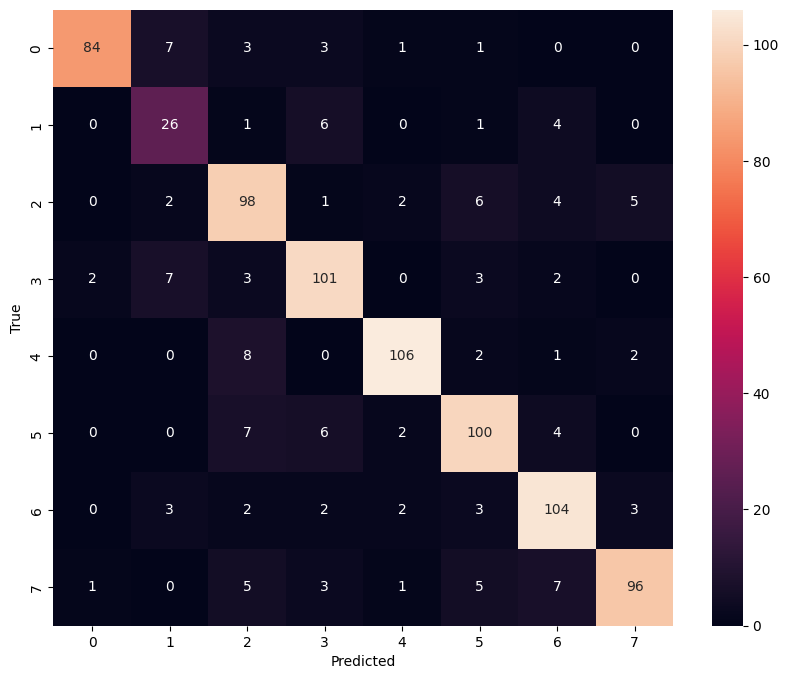

In [8]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]}")

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

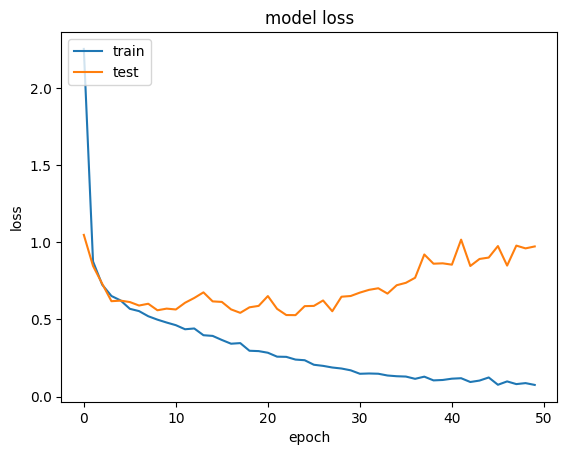

In [9]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

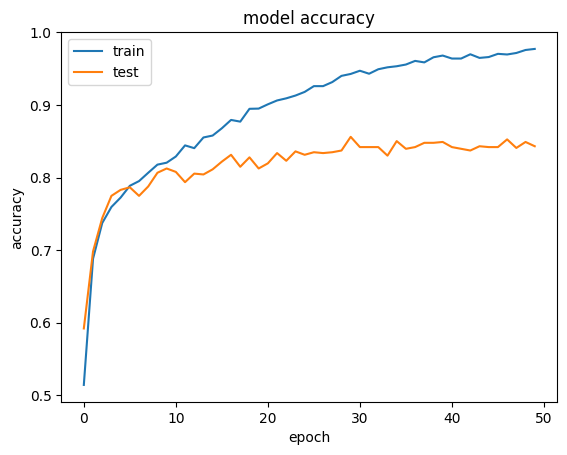

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [11]:
# Perform k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store accuracy for each fold
cv_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Reshape data to fit the model: (num_samples, timesteps, num_features)
    X_train_cv = np.expand_dims(X_train_cv, axis=-1)
    X_val_cv = np.expand_dims(X_val_cv, axis=-1)

    # Initialize a new model for each fold
    model_cv = Sequential()

    model_cv.add(
        Conv1D(
            64,
            5,
            padding="same",
            input_shape=(X_train_cv.shape[1], X_train_cv.shape[2]),
        )
    )
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(128, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(256, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))

    model_cv.add(Flatten())

    model_cv.add(Dense(8))
    model_cv.add(Activation("softmax"))

    # Define a new RMSprop optimizer with a lower learning rate for each fold
    opt_cv = RMSprop(learning_rate=0.001)

    model_cv.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt_cv, metrics=["accuracy"]
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=1)

    # Evaluate the model on validation data
    y_val_pred = model_cv.predict(X_val_cv)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val_cv, y_val_pred_classes)
    cv_accuracies.append(accuracy)

# Print cross-validation accuracies and mean accuracy
print(f"Cross-validation accuracies: {cv_accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(cv_accuracies)}")

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4018 - loss: 3.7021
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7005 - loss: 0.8393
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7403 - loss: 0.7273
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7794 - loss: 0.6204
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7678 - loss: 0.6360
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8016 - loss: 0.5206
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8058 - loss: 0.5307
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8157 - loss: 0.4999
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8231 - loss: 0.4845
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8275 - loss: 0.4555
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8394 - loss: 0.4360
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3767 - loss: 4.5542
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6968 - loss: 0.8752
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7085 - loss: 0.7807
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7590 - loss: 0.6670
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7678 - loss: 0.6383
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7923 - loss: 0.5636
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7950 - loss: 0.5616
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7922 - loss: 0.5557
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8265 - loss: 0.4677
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8057 - loss: 0.5040
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8220 - loss: 0.4736
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3804 - loss: 3.6656
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6941 - loss: 0.8855
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7415 - loss: 0.7297
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7591 - loss: 0.6643
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7786 - loss: 0.6140
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7936 - loss: 0.5660
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7951 - loss: 0.5663
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8246 - loss: 0.4878
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8140 - loss: 0.5095
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8379 - loss: 0.4663
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8421 - loss: 0.4526
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4070 - loss: 3.9133
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7023 - loss: 0.8704
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7414 - loss: 0.7070
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7374 - loss: 0.7017
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7723 - loss: 0.6146
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7858 - loss: 0.5624
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8160 - loss: 0.5060
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8193 - loss: 0.5020
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8192 - loss: 0.4932
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8257 - loss: 0.4959
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8342 - loss: 0.4499
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3698 - loss: 4.3221
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6698 - loss: 0.9248
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7257 - loss: 0.7663
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7512 - loss: 0.6739
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7731 - loss: 0.5983
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7891 - loss: 0.5644
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7980 - loss: 0.5315
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8130 - loss: 0.5180
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8208 - loss: 0.4808
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8086 - loss: 0.5057
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8379 - loss: 0.4564
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 